In [1]:
### Jinrui Zhou
### MCB112 PSET10: The Adventure of the Moonlighting Genes

In [1]:
import math
import random
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

In [2]:
%matplotlib inline

###### Set up default variables using N ≃ 100, M ≃ 60, R ≃ 3-6, and C≃90000−110000 per sample.

In [3]:
N = 100
M = 60
R = 5

In [4]:
c_max = 110000
c_min = 90000

###### Check on Adler's dataset.

In [5]:
lab_RNA_data = pd.read_table('w10-data.tbl.txt', header=None, delim_whitespace=True, index_col=0)
lab_RNA_data

,1,2,3,4,5,6,7,8,9,10,...,51,52,53,54,55,56,57,58,59,60
0,,,,,,,,,,,,,,,,,,,,,
anise,1001,202,327,608,176,237,285,440,926,86,...,476,1095,77,909,1123,148,540,61,976,185
apricot,565,1061,182,531,224,999,1019,1109,562,233,...,376,132,452,550,621,1386,1625,93,169,247
artichoke,1950,3851,639,2010,840,3798,3630,3893,2019,848,...,1453,509,1554,1999,2256,4906,5662,292,580,847
arugula,1175,2648,384,1369,531,2367,2346,2492,1320,505,...,877,278,984,1256,1502,3143,3679,213,372,546
asparagus,1368,4152,415,707,6866,372,2326,1241,562,2187,...,1539,2285,3376,3123,1667,3304,696,683,4332,6990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wasabi,81,261,25,50,406,20,135,77,31,128,...,83,143,217,217,95,210,46,45,266,449
watercress,89,72,444,281,120,365,177,251,226,364,...,269,78,238,68,34,19,63,511,81,29
watermelon,679,2083,180,330,3463,174,1097,563,266,1085,...,718,1103,1732,1554,843,1625,332,350,2141,3412


# 1. Write a function that simulates positive control data.
### Using the generative model assumed by NMF, write a function that generates synthetic data for N genes and M experiments, generated from R underlying gene batteries. Visualize gene battery assignments to demonstrate that the function generates reasonable data.

In [6]:
def data_generater(N, M, R):
    W = np.zeros((N, R))
    genes = [np.random.choice(N) for i in range(random.randint(2, 5))] 
    for i in range(N):
        j = np.random.choice(R)
        W[i][j] = 1
        if i in genes:
            if (j - 1) in range(R):
                W[i][j - 1] = 1 
            else: 
                W[i][j + 1] = 1
    csum = np.sum(W, axis=0)
    for i in range(N):
        W[i][:] = W[i][:] / csum
    H = np.random.dirichlet(np.ones(R),M).T
    C = np.random.choice(range(c_min, c_max), M)
    Vexp = C*(W@H)
    Vtrue = Vexp + np.random.poisson(Vexp) 
    return Vtrue, Vexp, W, H

In [7]:
Vtrue, Vexp, W, H = data_generater(N, M ,R)

In [8]:
print(len(Vtrue))
print(len(Vexp))
print(len(W[0]))
print(len(H))

100
100
5
5


###### Check if gene batteries containing 10-40 genes each.

In [9]:
m1 = []
m2 = []
m3 = []
m4 = []
m5 = []
for i in range(0, 100):
    for j in range(0, 5):
        if j == 0:
            m1.append(W[i][j])
        if j == 1:
            m2.append(W[i][j])
        if j == 2:
            m3.append(W[i][j])
        if j == 3:
            m4.append(W[i][j])
        if j == 4:
            m5.append(W[i][j])

In [10]:
print("Gene Battery 1:", np.count_nonzero(m1), "genes.")
print("Gene Battery 2:", np.count_nonzero(m2), "genes.")
print("Gene Battery 3:", np.count_nonzero(m3), "genes.")
print("Gene Battery 4:", np.count_nonzero(m4), "genes.")
print("Gene Battery 5:", np.count_nonzero(m5), "genes.")

Gene Battery 1: 19 genes.
Gene Battery 2: 25 genes.
Gene Battery 3: 15 genes.
Gene Battery 4: 21 genes.
Gene Battery 5: 24 genes.


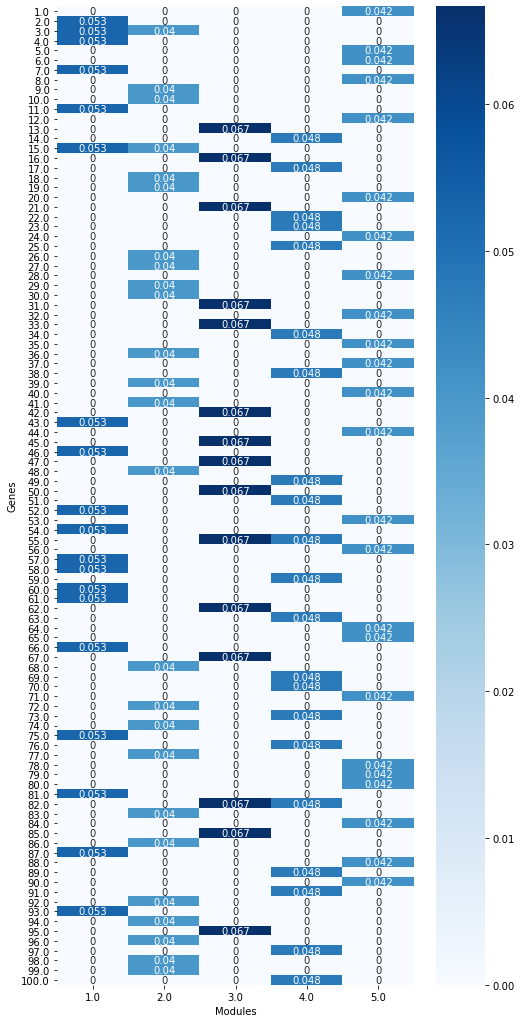

In [11]:
plt.figure(figsize=(8,18))
rows = np.linspace(1, N, N)
sns.heatmap(W, xticklabels = np.linspace(1, R, R), yticklabels = np.linspace(1, N, N), annot=True, cmap="Blues")
plt.xlabel('Modules')
plt.ylabel("Genes")
plt.show()

#### From the heatmap plotted above using the data generated by the data generator function, we can see each module has genes with the same values such as 0.036 for module 1 and 0.043 for module 2.

# 2. Implement nonnegative matrix factorization.
### Implement NMF, following the description in Lee and Seung (1999). Explain steps.

In [12]:
def NMF(Vtrue, R):
    ll_list = []
    ll = float('inf')      
    ll_diff = float('inf')  
    
    ## Initialization 
    W = np.random.dirichlet(np.ones(N),R).T
    H = np.random.dirichlet(np.ones(R),M).T
    C = np.sum(Vtrue,axis = 0)  
    Vexp = C*(W@H)
    
    # Update values 
    while ll_diff > 0.01:    
        ## normalization
        H = H * (W.T@(Vtrue / Vexp))
        W = W * (((Vtrue*C) / Vexp)@H.T)
        W = W / np.sum(W, axis = 0)  
        Vexp = C*(W@H)
        # Calculate the log-likelihood
        ll_new = np.sum(Vtrue * np.log(Vexp) - Vexp) 
        ll_list.append(ll_new)
        ll_diff = abs(ll_new - ll)
        ll = ll_new   
    return W, H, ll_list

#### W and H are initialized using the random function. The while loop is keeping track of if it meets the threshold condition, which is set to be 0.01 in this case. If it does not satisfiy the condition, it keeps updating the values of H and W with normalization and the log-likelihood is calculated respectively. Once the condition is satisfied, the value of W, H and the log-likelihood list are returned.

In [13]:
W,H,ll_list= NMF(Vtrue, R)

In [14]:
print(len(W))
print(len(H[0]))
print(len(ll_list))

100
60
1287


# 3. Test implementation. 
### Apply the NMF function to synthetic datasets that are generated, varying the parameters of the synthetic data. What conclusions can be drawn about how well NMF reconstructs the known gene batteries in the synthetic data? Explain findings.

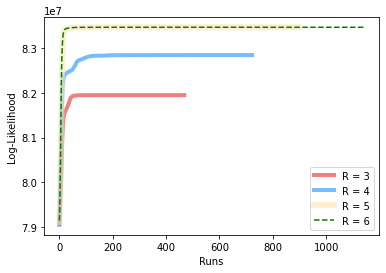

In [15]:
convergence = []
W_list = []
for R in range(3,7):
    W, H,ll_list = NMF(Vtrue, R)
    if R == 3:
        plt.plot(ll_list,label = f"R = {R}", color = "lightcoral", linewidth = 4)
    if R == 4:
        plt.plot(ll_list,label = f"R = {R}", color = "dodgerblue", linewidth = 4, alpha = 0.6)
    if R == 5:
        plt.plot(ll_list,label = f"R = {R}", color = "moccasin", linewidth = 6, alpha = 0.6)
    if R == 6:
        plt.plot(ll_list,label = f"R = {R}", linestyle ='dashed', color = "green")
    convergence.append(ll_list[-1])
    W_list.append(W)
plt.legend()
plt.xlabel("Runs")
plt.ylabel("Log-Likelihood")
plt.show()

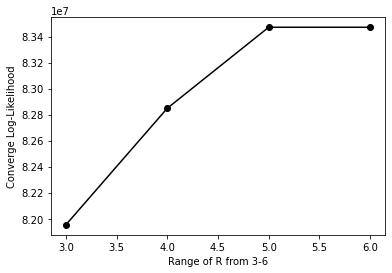

In [16]:
plt.xlabel("Range of R from 3-6")
plt.ylabel("Converge Log-Likelihood")
plt.plot(range(3,7), convergence, marker = "o", color="black")

#### Based on the plots, there are 5 gene batteries in the randomly generated data as the converge log-likelihood stops increasing at R=5. In the first plot, the curve for R=5 and R=6 are largely overlapping with each other, and there are no such an issue of overlapping for the curves associated with R=3 and R=4, meaning that they are at different level along with the giant gaps.

# 4. Analyze the Adler data. 
### Apply the NMF analysis to the Adler dataset. What is the best guess for how many gene batteries (NMF clusters) there are, and why? How many genes are in each battery, and what are they? How many moonlighting genes are there, and what are they?

In [17]:
VT = lab_RNA_data.to_numpy()
VT

array([[1001,  202,  327, ...,   61,  976,  185],
       [ 565, 1061,  182, ...,   93,  169,  247],
       [1950, 3851,  639, ...,  292,  580,  847],
       ...,
       [ 679, 2083,  180, ...,  350, 2141, 3412],
       [ 696,  498, 3436, ..., 3796,  487,  236],
       [ 931,  173,  216, ...,   31,  831,  156]])

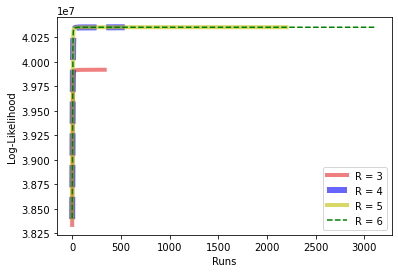

In [18]:
convergence2 = []
for R in range(3,7):
    W2, H2, ll2 = NMF(VT, R)
    convergence2.append(ll2[-1])
    if R == 3:
        plt.plot(ll2,label = f"R = {R}", color = "lightcoral", linewidth = 4)
    if R == 4:
        plt.plot(ll2,label = f"R = {R}", color = "blue", linewidth = 6, alpha = 0.6, linestyle = "--")
    if R == 5:
        plt.plot(ll2,label = f"R = {R}", color = "y", linewidth = 4, alpha = 0.6)
    if R == 6:
        plt.plot(ll2,label = f"R = {R}", linestyle ='dashed', color = "green")
plt.legend()      
plt.xlabel("Runs")
plt.ylabel("Log-Likelihood")
plt.show()

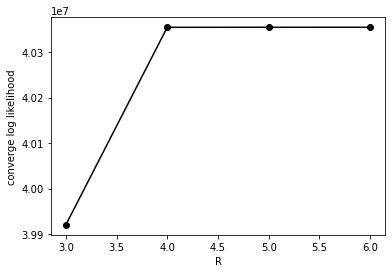

In [19]:
plt.xlabel("R")
plt.ylabel("converge log likelihood")
plt.plot(range(3,7),convergence2, marker = "o", color="black")

#### Since the second plot shows that the curve stops converging at R=4, the best guess for the number of gene batteries is 4 with th same idea used in the previous analysis.

In [20]:
R2 = 4

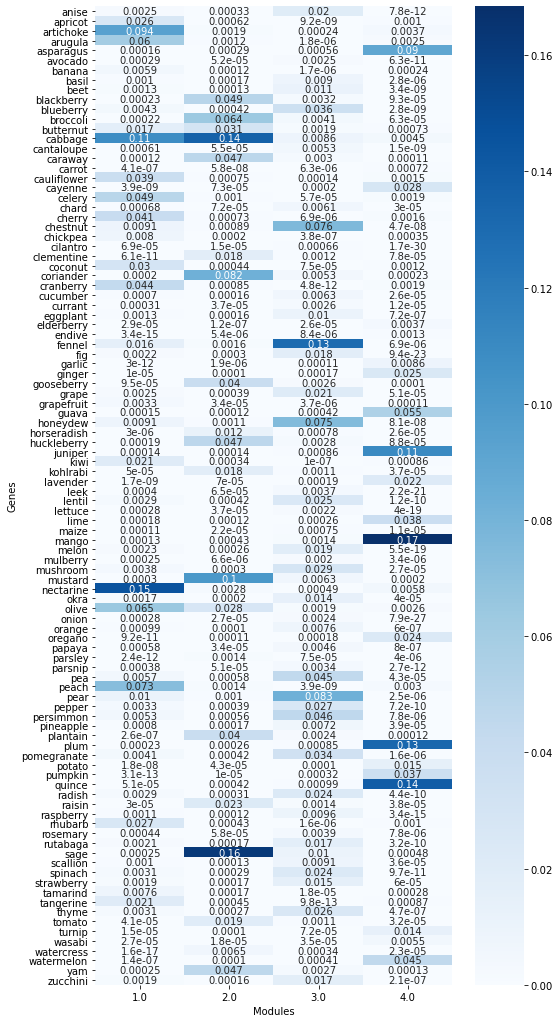

In [21]:
W, H, ll = NMF(VT, R2)
plt.figure(figsize=(8,18))
sns.heatmap(W, xticklabels =np.linspace(1,R2,R2) , yticklabels = lab_RNA_data.index, annot=True, cmap="Blues")
plt.xlabel('Modules')
plt.ylabel("Genes")
plt.show()

Text(0, 0.5, 'Frequency')

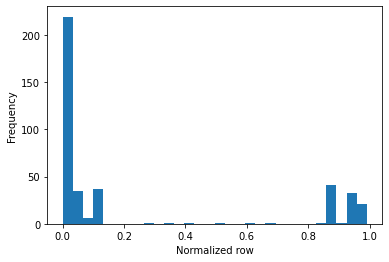

In [22]:
W = normalize(W, axis=1, norm='l1')  
plt.hist(W.flatten(), bins=30)
plt.xlabel('Normalized row')
plt.ylabel('Frequency')

#### The thrid bar of the histogram shown above counted from left to right seem very close to 0.1, and the threshold can be set to 0.12 to make the significance level tight and safe.

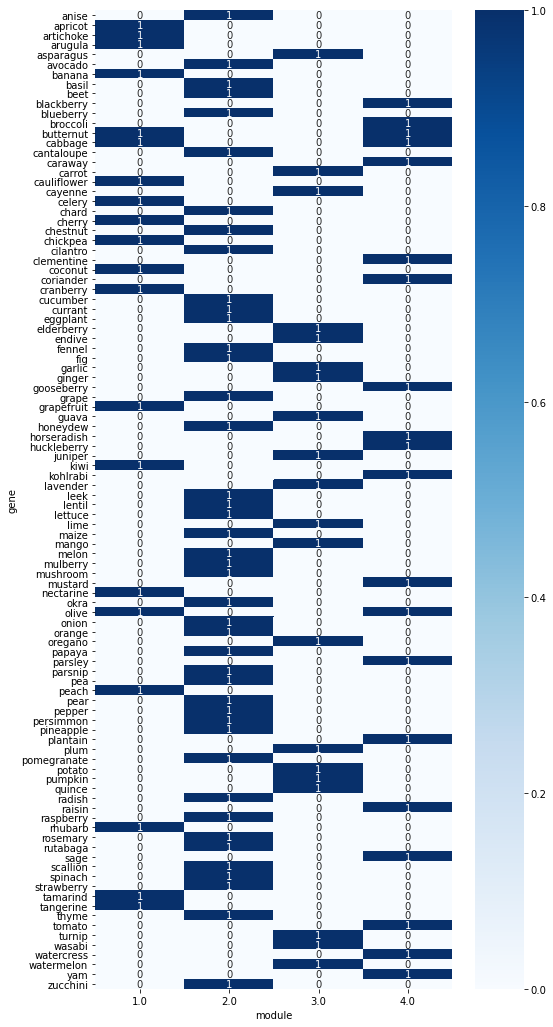

In [28]:
threshold = 0.12
Wb = np.where(W > threshold, 1, 0)
plt.figure(figsize=(8,18))
sns.heatmap(Wb, xticklabels =np.linspace(1,R2,R2) , yticklabels = lab_RNA_data.index, annot=True, cmap="Blues")
plt.xlabel('module')
plt.ylabel("gene")
plt.show()

In [29]:
gene_list = lab_RNA_data.index

In [30]:
b1 = []
b2 = []
b3 = []
b4 = []
for i in range(N):
    if Wb[i][0] >= 1:
        b1.append(gene_list[i])
    if Wb[i][1] >= 1:
        b2.append(gene_list[i])
    if Wb[i][2] >= 1:
        b3.append(gene_list[i])
    if Wb[i][3] >= 1:
        b4.append(gene_list[i])
print("***** Number of genes in each battery *****")
print("*%i genes are in gene battery 1:\n   %s\n"%(len(b1),", ".join(b1)))
print("*%i genes are in gene battery 2:\n   %s\n"%(len(b2),", ".join(b2)))
print("*%i genes are in gene battery 3:\n   %s\n"%(len(b3),", ".join(b3)))
print("*%i genes are in gene battery 4:\n   %s\n"%(len(b4),", ".join(b4)))

***** Number of genes in each battery *****
*20 genes are in gene battery 1:
   apricot, artichoke, arugula, banana, butternut, cabbage, cauliflower, celery, cherry, chickpea, coconut, cranberry, grapefruit, kiwi, nectarine, olive, peach, rhubarb, tamarind, tangerine

*43 genes are in gene battery 2:
   anise, avocado, basil, beet, blueberry, cantaloupe, chard, chestnut, cilantro, cucumber, currant, eggplant, fennel, fig, grape, honeydew, leek, lentil, lettuce, maize, melon, mulberry, mushroom, okra, onion, orange, papaya, parsnip, pea, pear, pepper, persimmon, pineapple, pomegranate, radish, raspberry, rosemary, rutabaga, scallion, spinach, strawberry, thyme, zucchini

*20 genes are in gene battery 3:
   asparagus, carrot, cayenne, elderberry, endive, garlic, ginger, guava, juniper, lavender, lime, mango, oregano, plum, potato, pumpkin, quince, turnip, wasabi, watermelon

*20 genes are in gene battery 4:
   blackberry, broccoli, butternut, cabbage, caraway, clementine, coriander, goos

In [33]:
moonlight_genes = []
for i in range(N):
    if np.sum(Wb[i][:])>1:
        moonlight_genes.append(gene_list[i])
print("***** Number of moonlighting genes *****")
print(" %i genes are moonlighting genes. \n They are %s"%(len(moonlight_genes), ", ".join(moonlight_genes)))

***** Number of moonlighting genes *****
 3 genes are moonlighting genes. 
 They are butternut, cabbage, olive
